In [1]:
import tensorflow as tf
model = tf.keras.models.load_model("../model/LSTM_3_3.keras")

In [2]:
from pandas import read_csv
#Load data set
series_influ_A_df = read_csv('../temp_data/influA_vietnam.csv', usecols=[1,2,3], engine='python')
# series_influ_A_df = series_influ_A_df["Influenza A - All types of surveillance"]
series_influ_A_df = series_influ_A_df.dropna()
series_influ_A_df = series_influ_A_df.astype('float32')
series_influ_A_df = series_influ_A_df.values
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(series_influ_A_df)
# Create Training and Test
train = dataset[:735, :]
test = dataset[735:, :]

In [7]:
import numpy as np
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [8]:
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [6]:
# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [33]:
import numpy as np

# Assuming you have an existing ndarray called original_array
original_array = np.array([[[1, 2, 3], [1, 2, 3]]])
print(original_array.shape)

# Create a new array containing values to append
values_to_append = np.array([[4, 5, 6],[4, 5, 6]])

# Append values_to_append to original_array along axis 0
appended_array = np.append(original_array, [values_to_append], axis=0)

# Print the appended array
print(appended_array.shape)

(1, 2, 3)
(2, 2, 3)


In [42]:
from sklearn.metrics import mean_squared_error
# [[1,3]] :shape 1,2
def predict_one(X, model):
    X= np.array([X])
    predicted = model.predict(X, verbose=0)
    return predicted[0]


#X_start: [[1,3]]
def predict(X_start, num_weeks, model):
    result = []
    X=np.array([X_start])
    for i in range(num_weeks):
        predicted = predict_one(X[i], model)
        result.append(predicted)
        X_continue = np.vstack((X[-1][-1], predicted.reshape(1,3)))
        X = np.append(X, [X_continue], axis=0)
    return result
    
# make predictions
# testPredict = model.predict(testX)
print(testX[0])
testPredict = predict(testX[0], len(testX), model)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform(testY)
# calculate root mean squared error
print(testPredict.shape)
testScore = np.sqrt(mean_squared_error(testY_[0], testPredict[0]))
print('Test Score: %.2f RMSE' % (testScore))

[[0.1707317  0.44268772 0.9376025 ]
 [0.19512194 0.6205534  0.7602627 ]]
(54, 3)
Test Score: 14.02 RMSE


[12.88745275 10.55649815  8.25631453  6.14341568  4.22269286  2.49304512
  0.95258435 -0.40788773 -1.59819792 -2.63035499 -3.51703734 -4.27150329
 -4.90706845 -5.43685108 -5.87347152 -6.22885976 -6.51411854 -6.73942198
 -6.91396544 -7.04596434 -7.14268468 -7.21046627 -7.25480885 -7.28041366
 -7.29128242 -7.29076434 -7.28165877 -7.26627022 -7.24646636 -7.22376965
 -7.19937451 -7.17423157 -7.14905503 -7.1243923  -7.10063193 -7.07806414
 -7.05686303 -7.03713676 -7.01892746 -7.00223943 -6.98704455 -6.97328418
 -6.96088316 -6.94977002 -6.93983846 -6.93101149 -6.92318769 -6.9162846
 -6.91020994 -6.9048727  -6.90020384 -6.8961331  -6.8925951  -6.88952387] [27. 21. 62.]


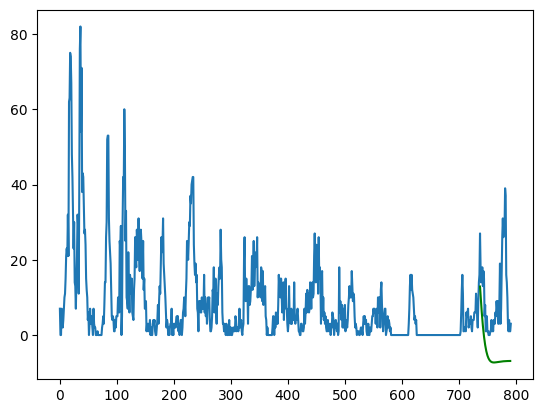

In [43]:
print(testPredict[:, 0], testY_[0])

import matplotlib.pyplot as plt
# (x,3)
testPredictPlot = np.empty([dataset.shape[0]])
testPredictPlot[:] = np.nan
testPredictPlot[len(trainX)+(look_back*2)+1:len(dataset)-1] = testPredict[:,0].reshape(-1)
plt.plot(scaler.inverse_transform(dataset)[:,0].reshape(-1))
plt.plot(testPredictPlot, color = 'green')
plt.show()